In [15]:
import matplotlib.pyplot as plt
from data import data
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder

In [16]:
# Create Column Names
columns = ['age', 'workclass', 'fnlwgt','education','education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain','capital-loss',
           'hours-per-week','native-country', 'money']

adult = data('./adult.data', './adult.test', columns)

# Drop rows with unknown values
adult.train_x.replace('\?',np.nan, inplace=True, regex=True)
adult.test_x.replace('\?', np.nan, inplace=True, regex=True)
adult.train_x.dropna(inplace=True)
adult.test_x.dropna(inplace=True)

# Encode money category to binary and create labels
def encode_money(df):
    lb = LabelBinarizer()
    binary = lb.fit_transform(df['money'])
    df.drop('money', axis=1, inplace=True)
    return df, pd.DataFrame(binary,columns=['money'])

adult.train_x, adult.train_y = encode_money(adult.train_x)
adult.test_x, adult.test_y = encode_money(adult.test_x)


# Do the onehotencoding
def transform_data(enc, data, column):
    enc_df = pd.DataFrame(enc.transform(data[[column]]).toarray(),columns=enc.categories_[0])
    for item in enc.categories_[0]:
        data[item.strip()] = enc_df[item].to_numpy()
    return data

# Set up the one hot encoding
def encode(df_train, df_test, column_name):
    # Creates the one hot encoder
    enc = OneHotEncoder()
    enc.fit(df_train[[column_name]])
    
    df_train = transform_data(enc, df_train, column_name)
    df_test = transform_data(enc, df_test, column_name)
    
    # Drops the old non-encoded data
    df_train.drop(column_name,axis=1, inplace=True)
    df_test.drop(column_name, axis=1, inplace=True)
    
    return df_train, df_test


# Sets the classes that need to be encoded
to_encode = ['workclass','education', 'marital-status', 'occupation',
             'relationship', 'race', 'sex', 'native-country']

# Encodes all the categories
for category in to_encode:
    adult.train_x, adult.test_x = encode(adult.train_x, adult.test_x, category)


clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
#print("Cross val score:")
#print(cross_val_score(clf, adult_train,adult_train_label, cv=10))

In [33]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
clf.fit(adult.train_x,adult.train_y)
predictions = clf.predict(adult.test_x)

tn, fp, fn, tp = confusion_matrix(adult.test_y.to_numpy(), predictions).ravel()
fp_rate = fp/(fp+tn)
report = classification_report(adult.test_y, predictions, output_dict=True)

print("{: <23}{: <10}".format("True Positive Rate:",report['1']['recall']))
print("{: <23}{: <10}".format("False Positive Rate:",fp_rate))

print(classification_report(adult.test_y, predictions))


dict_keys(['0', '1', 'accuracy', 'macro avg', 'weighted avg'])
True Positive Rate:    0.5356756756756756
False Positive Rate:   0.07210141737829034
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     11359
           1       0.71      0.54      0.61      3700

    accuracy                           0.83     15059
   macro avg       0.78      0.73      0.75     15059
weighted avg       0.82      0.83      0.82     15059



In [20]:
nb = GaussianNB()
nb.fit(adult.train_x, adult.train_y.values.ravel())
predictions = nb.predict(adult.test_x)

tn, fp, fn, tp = confusion_matrix(adult.test_y.to_numpy(), predictions).ravel()
ac, tp_rate, fp_rate, precision, recall, f = get_metrics(tn,fp, fn, tp)
print("{: <23}{: <10}".format("Accuracy",ac))
print("{: <23}{: <10}".format("True Positive Rate:",tp_rate))
print("{: <23}{: <10}".format("False Positive Rate:",fp_rate))
print("{: <23}{: <10}".format("Precision:",precision))
print("{: <23}{: <10}".format("Recall:",recall))
print("{: <23}{: <10}".format("f1_score:",f))

print(classification_report(adult.test_y, predictions))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     11359
           1       0.65      0.31      0.42      3700

    accuracy                           0.79     15059
   macro avg       0.73      0.63      0.64     15059
weighted avg       0.77      0.79      0.76     15059



In [21]:
def average_binary(data):
    avg = data.mean()
    data = data.to_numpy()
    for index, item in enumerate(data):
        if item <= avg:
            data[index] = 0.0
        else:
            data[index] = 1.0
    return data

to_binary = ['age', 'fnlwgt', 'education-num', 
             'capital-gain', 'capital-loss', 
             'hours-per-week']

for category in to_binary:
    adult.train_x[category] = average_binary(adult.train_x[category])
    adult.test_x[category] = average_binary(adult.test_x[category])


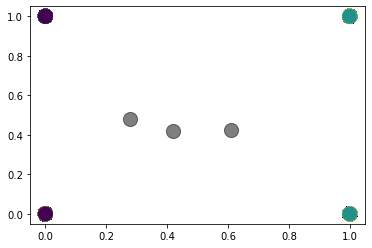

In [22]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(adult.train_x)
y_kmeans = kmeans.predict(adult.train_x)
plt.scatter(adult.train_x.iloc[:,0], adult.train_x.iloc[:,1], s=200, c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);